# Predicting Informal Caregiving in Europe
## A Data Analytics Study Using European Social Survey (ESS) Round 7 Data

### Project Overview
This project investigates the predictors of informal caregiving using sociodemographic data from the European Social Survey (ESS). Informal caregiving is unpaid care provided by individuals for relatives or friends. This type of care is crucial given Europe's ageing population. This analysis identifies key predictors of caregiving and builds a predictive logistic regression model.


### Why This Project Matters
- **Demographic Challenges**: With a rising population aged over 65, informal caregiving is increasingly significant
- **Economic Value**: Informal caregiving contributes an estimated €576 billion to Europe's economy annually (3.63% of GDP)
- **Policy Implications**: Insights can help policymakers design targeted support programs


### Project Goals
1. 🎯 Identify sociodemographic factors predicting informal caregiving
2. 🔍 Build a logistic regression classifier 
3. 📊 Evaluate model performance and provide policy insights


### Tools & Methods
- RStudio with dplyr, ROSE, and ggplot2
- Logistic regression for prediction
- CRISP-DM methodology for analysis

### Data Preparation 📊

In [ ]:
# Install required packages
install.packages("DescTools")
install.packages("dplyr")
install.packages("ROSE")
install.packages("ggplot2")
install.packages("glmnet")
install.packages("caret")
install.packages("randomForest")
install.packages("forcats")
install.packages("gridExtra")


# Load the packages
library(DescTools)  
library(dplyr)
library(ROSE)
library(ggplot2)
library(glmnet)
library(caret)
library(randomForest)
library(forcats)
library(gridExtra)

# Suppress dplyr summarise grouping messages
options(dplyr.summarise.inform = FALSE)

### Data Overview
- **Source**: European Social Survey, Round 7
- **Scope**: 40,185 observations, 602 variables
- **Focus**: Sociodemographic predictors of caregiving

In [99]:
# Reading and preparing the data
data <- read.csv("./Data/ESS7e02_3.csv")
options(dplyr.summarise.inform = FALSE)

# Creating a subset of relevant sociodemographic variables
subset_data <- subset(data, select=c(blgetmg, rlgdgr, hlpfmly, gndr, agea, hhmmb, marsts, eisced, emplrel))

# Using rename() to make variable names more intuitive
subsetdata <- subset_data %>%
  rename(
    gender = gndr,
    marital_status = marsts,
    belong_to_ethnic_minority = blgetmg,
    how_religious = rlgdgr,
    informal_carer = hlpfmly,
    age = agea,
    family_size = hhmmb,
    education_level = eisced,
    employment = emplrel
  )

### Initial Data Exploration 🔍
Using the head() function to view the first few rows of the dataset and the summary() function to get a summary of each variable. We are also using the str() function to check the structure of the dataset. This will give us a good overview of the data and help us understand the variables.

In [100]:
# View the first few rows of the dataset
head(subsetdata)

# Get a summary of each variable
summary(subsetdata)

# Check the structure of the dataset
str(subsetdata)

,belong_to_ethnic_minority,how_religious,informal_carer,gender,age,family_size,marital_status,education_level,employment
,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
1,2,4,2,1,51,1,6,3,1
2,2,3,2,1,67,2,4,1,1
3,2,4,2,2,89,1,5,1,6
4,2,5,1,1,32,3,6,3,1
5,2,8,1,2,56,6,66,3,1
6,2,2,2,2,67,2,66,3,1


 belong_to_ethnic_minority how_religious    informal_carer      gender     
 Min.   :1.000             Min.   : 0.000   Min.   :1.000   Min.   :1.000  
 1st Qu.:2.000             1st Qu.: 2.000   1st Qu.:1.000   1st Qu.:1.000  
 Median :2.000             Median : 5.000   Median :2.000   Median :2.000  
 Mean   :2.017             Mean   : 4.942   Mean   :1.704   Mean   :1.534  
 3rd Qu.:2.000             3rd Qu.: 7.000   3rd Qu.:2.000   3rd Qu.:2.000  
 Max.   :9.000             Max.   :99.000   Max.   :9.000   Max.   :9.000  
      age          family_size     marital_status  education_level 
 Min.   : 14.00   Min.   : 1.000   Min.   : 1.00   Min.   : 1.000  
 1st Qu.: 34.00   1st Qu.: 2.000   1st Qu.: 6.00   1st Qu.: 2.000  
 Median : 50.00   Median : 2.000   Median : 6.00   Median : 4.000  
 Mean   : 51.62   Mean   : 2.839   Mean   :35.44   Mean   : 4.332  
 3rd Qu.: 64.00   3rd Qu.: 4.000   3rd Qu.:66.00   3rd Qu.: 5.000  
 Max.   :999.00   Max.   :99.000   Max.   :99.00   Max.   :9

'data.frame':	40185 obs. of  9 variables:
 $ belong_to_ethnic_minority: int  2 2 2 2 2 2 2 1 2 2 ...
 $ how_religious            : int  4 3 4 5 8 2 6 5 4 5 ...
 $ informal_carer           : int  2 2 2 1 1 2 1 1 2 2 ...
 $ gender                   : int  1 1 2 1 2 2 1 2 2 2 ...
 $ age                      : int  51 67 89 32 56 67 66 67 34 66 ...
 $ family_size              : int  1 2 1 3 6 2 2 1 2 2 ...
 $ marital_status           : int  6 4 5 6 66 66 66 4 6 66 ...
 $ education_level          : int  3 1 1 3 3 3 3 5 7 3 ...
 $ employment               : int  1 1 6 1 1 1 1 1 1 2 ...


### Data Cleaning Strategy 🧹
As we can see from the summary, the values are encoded. We need to convert them to factors with meaningful labels. These labels have been taken from the ESS documentation. Further on, we will remove rows with invalid responses and filter out observations with age under 18. We will also drop the marital_status variable as there are too many missing values. Education level will be grouped into primary, secondary, vocational and third level.

In [101]:
# Converting categorical variables to factors with meaningful labels
subsetdata$belong_to_ethnic_minority <- factor(subsetdata$belong_to_ethnic_minority,
    levels = c(1, 2, 7, 8, 9),
    labels = c("Yes", "No", "Refusal", "Don't know", "No answer")
)

subsetdata$informal_carer <- factor(subsetdata$informal_carer,
    levels = c(2, 1, 7, 8, 9),
    labels = c("No", "Yes", "Refusal", "Don't know", "No answer")
)

subsetdata$gender <- factor(subsetdata$gender,
    levels = c(1, 2, 9),
    labels = c("Male", "Female", "No answer")
)

subsetdata$education_level <- factor(subsetdata$education_level,
    levels = c(0, 1, 2, 3, 4, 5, 6, 7, 55, 77, 88, 99),
    labels = c(
        "Not possible to harmonise into ES-ISCED",
        "ES-ISCED I, less than lower secondary",
        "ES-ISCED II, lower secondary",
        "ES-ISCED IIIb, lower tier upper secondary",
        "ES-ISCED IIIa, upper tier upper secondary",
        "ES-ISCED IV, advanced vocational, sub-degree",
        "ES-ISCED V1, lower tertiary education, BA level",
        "ES-ISCED V2, higher tertiary education, >= MA level",
        "Other",
        "Refusal",
        "Don't know",
        "No answer"
    ),
    ordered = TRUE
)

### Data Visualization 📊
Exploring the data through visualizations helps identify important relationships. We will create a subset of the data that contains only the informal carer status and gender. We will then create a bar plot to visualize the distribution of informal carers by gender. We will also create a histogram to visualize the age distribution by carer status and a bar plot to visualize the proportion of carers by gender. 

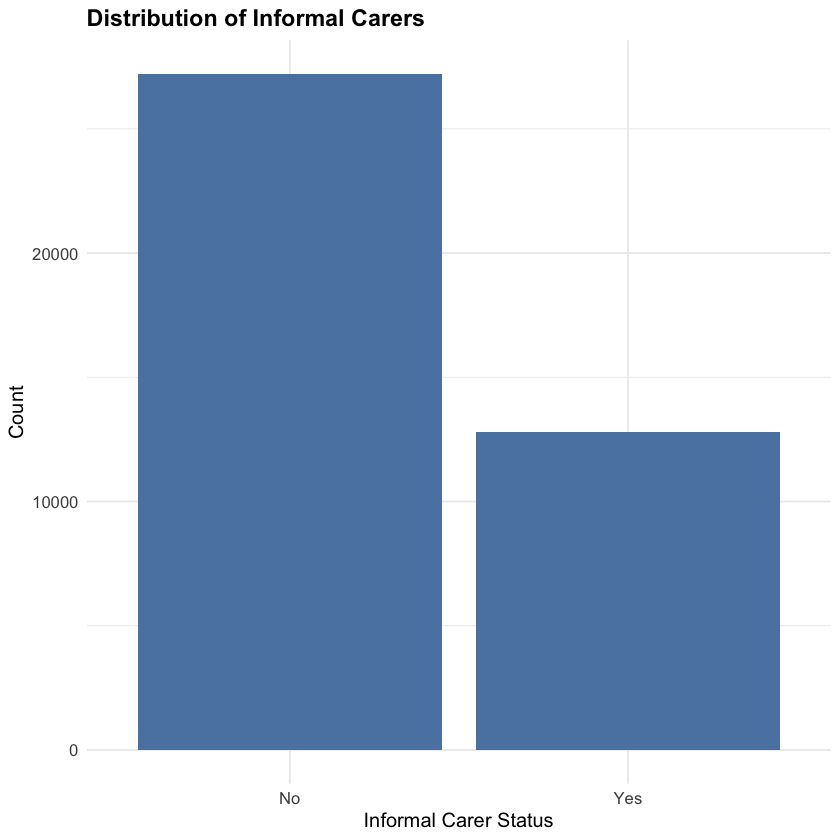

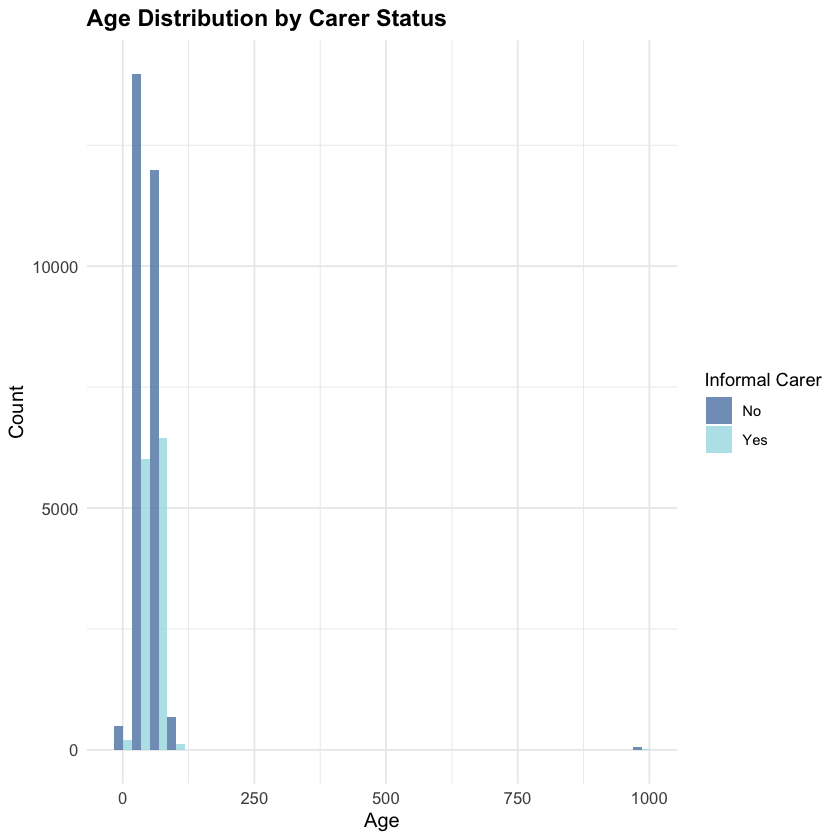

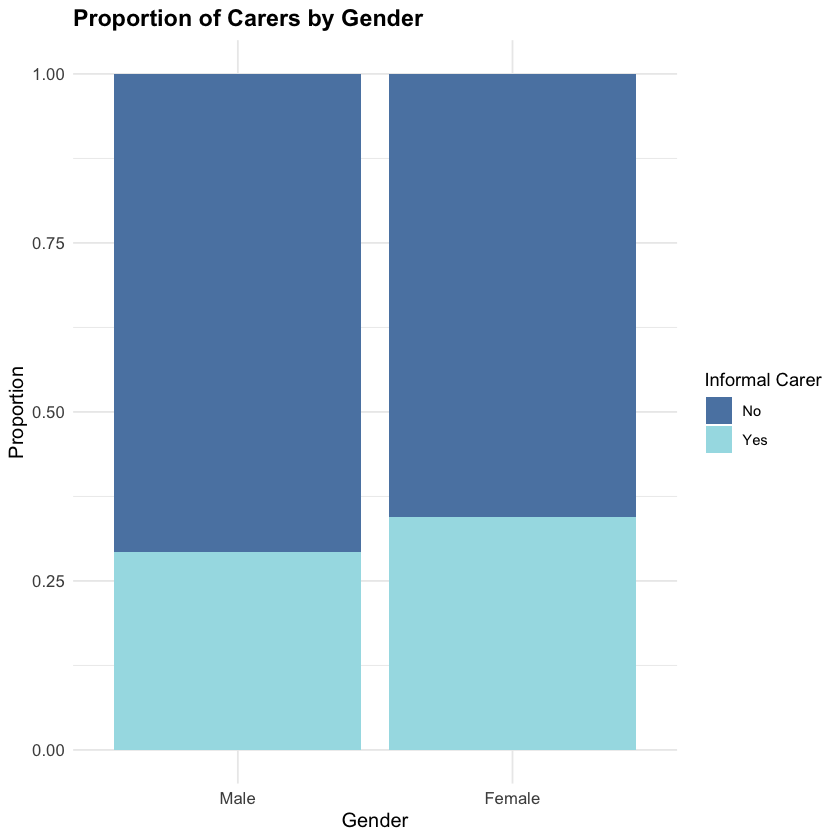

In [102]:
# Create clean subset for visualization
viz_data <- subsetdata %>%
  filter(informal_carer %in% c("Yes", "No"),
         gender %in% c("Male", "Female"))

# Visualize informal carer distribution
ggplot(viz_data, aes(x = informal_carer)) +
  geom_bar(fill = "#5B84B1") +  # Dusty blue
  labs(title = "Distribution of Informal Carers",
       x = "Informal Carer Status",
       y = "Count") +
  theme_minimal() +
  theme(
    plot.title = element_text(size = 14, face = "bold"),
    axis.title = element_text(size = 12),
    axis.text = element_text(size = 10)
  )

# Age distribution by carer status
ggplot(viz_data, aes(x = age, fill = informal_carer)) +
  geom_histogram(position = "dodge", bins = 30, alpha = 0.8) +
  scale_fill_manual(values = c("#5B84B1", "#A5DEE5")) +  # Dusty blue and light turquoise
  labs(title = "Age Distribution by Carer Status",
       x = "Age",
       y = "Count",
       fill = "Informal Carer") +
  theme_minimal() +
  theme(
    plot.title = element_text(size = 14, face = "bold"),
    axis.title = element_text(size = 12),
    axis.text = element_text(size = 10)
  )

# Gender distribution among carers
ggplot(viz_data, aes(x = gender, fill = informal_carer)) +
  geom_bar(position = "fill") +
  scale_fill_manual(values = c("#5B84B1", "#A5DEE5")) +  # Dusty blue and light turquoise
  labs(title = "Proportion of Carers by Gender",
       x = "Gender",
       y = "Proportion",
       fill = "Informal Carer") +
  theme_minimal() +
  theme(
    plot.title = element_text(size = 14, face = "bold"),
    axis.title = element_text(size = 12),
    axis.text = element_text(size = 10)
  )

### Data Cleaning Continued 🧹
We will now remove rows from the subsetdata that contain irrelevant responses. We will also drop the marital_status variable as there are too many missing values. Education level will be grouped into primary, secondary, vocational and third level.

In [103]:
# Removing rows from subsetdata that contain irrelevant responses
clean_data <- subsetdata %>%
  filter(
    !belong_to_ethnic_minority %in% c("Don't know", "Refusal", "No answer"),
    !how_religious %in% c("77", "88", "99"),
    !informal_carer %in% c("Don't know", "Refusal", "No answer"),
    !gender %in% c("No answer"),
    !age %in% c("999"),
    !family_size %in% c("77", "88", "99"),
    !marital_status %in% c("Don't know", "Refusal", "No answer"),
    !education_level %in% c("Don't know", "Refusal", "No answer", "Other"),
    !employment %in% c("Don't know", "Refusal", "No answer")
  )

# cleaner_data <- clean_data %>%
# mutate(across(where(is.factor), fct_drop))

cleaner_data <- clean_data %>%
  mutate(across(where(is.factor), droplevels))


# Filter out observations with age under 18 and drop the marital_status variable
cleanest_data <- cleaner_data %>%
  filter(age >= 18) %>%
  select(-marital_status)


Next, We will prepare the data for modeling by grouping education levels and creating balanced datasets. We will also create a bar plot to visualize the proportion of carers by education level.

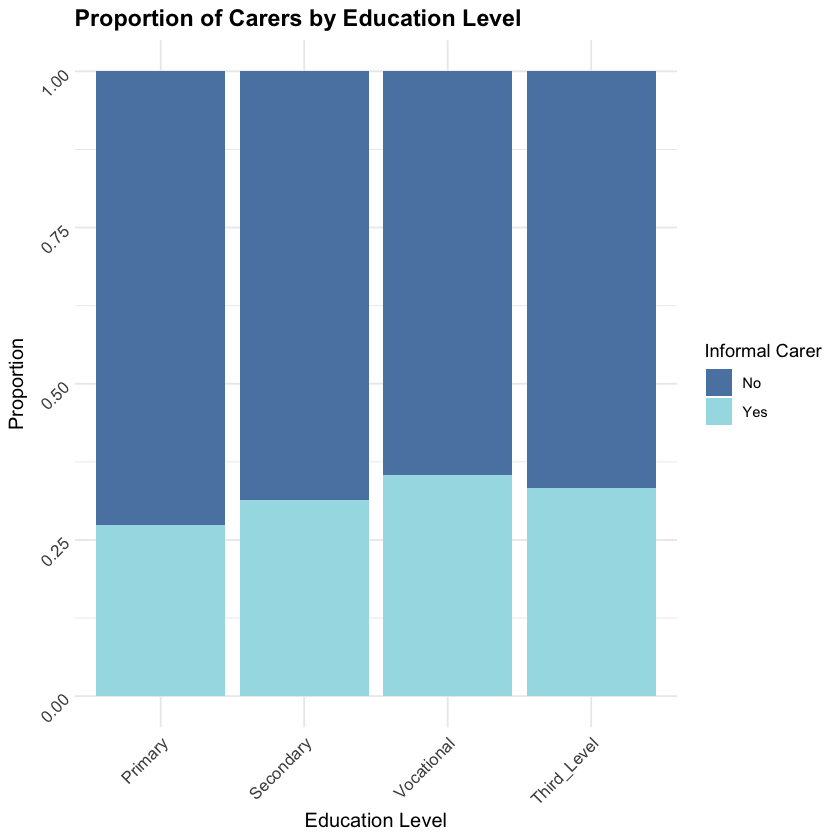

In [104]:
# Grouping education levels to reduce complexity
cleanest_data <- cleanest_data %>%
  mutate(education_level = fct_collapse(education_level,
    Primary = c("ES-ISCED I, less than lower secondary"),
    Secondary = c(
      "ES-ISCED II, lower secondary",
      "ES-ISCED IIIb, lower tier upper secondary",
      "ES-ISCED IIIa, upper tier upper secondary"
    ),
    Vocational = c("ES-ISCED IV, advanced vocational, sub-degree"),
    Third_Level = c(
      "ES-ISCED V1, lower tertiary education, BA level",
      "ES-ISCED V2, higher tertiary education, >= MA level"
    )
  ))

# Visualize education levels among carers
ggplot(cleanest_data, aes(x = education_level, fill = informal_carer)) +
  geom_bar(position = "fill") +
  scale_fill_manual(values = c("#5B84B1", "#A5DEE5")) +
  labs(title = "Proportion of Carers by Education Level",
       x = "Education Level",
       y = "Proportion",
       fill = "Informal Carer") +
  theme_minimal() +
  theme(
    plot.title = element_text(size = 14, face = "bold"),
    axis.title = element_text(size = 12),
    axis.text = element_text(size = 10, angle = 45, hjust = 1)
  )

### Model Preparation 📊
We'll split our data into training and validation sets, then create a balanced dataset for training.

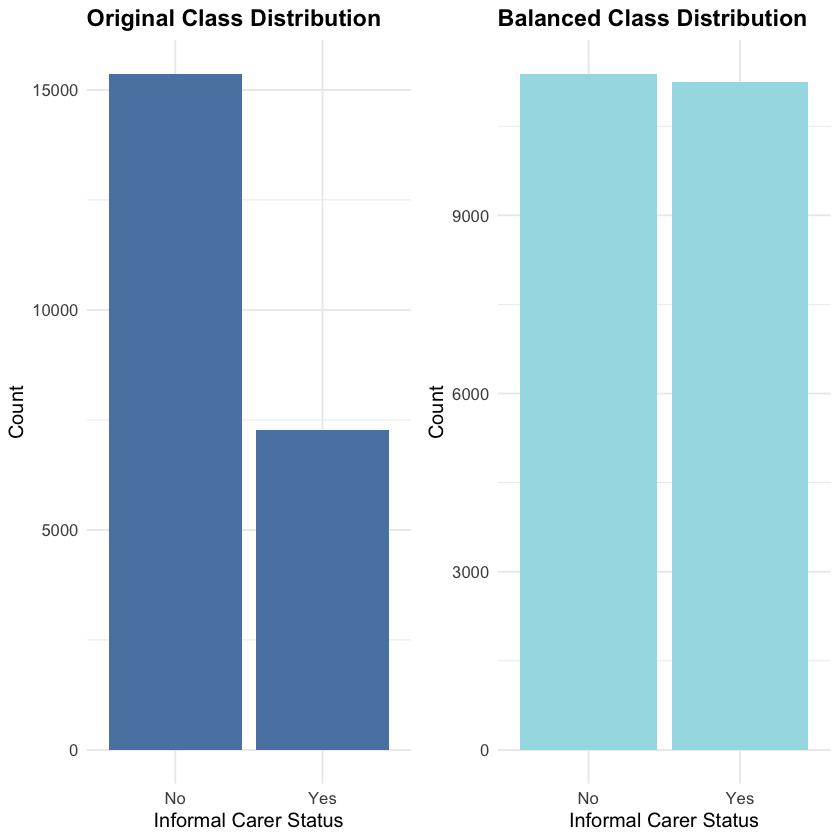

In [105]:
# Ensuring dependent variable is 8th variable
cleanest_data <- cleanest_data %>% 
  select(belong_to_ethnic_minority, how_religious, gender, age, 
         family_size, education_level, employment, informal_carer)

# Splitting the data
set.seed(123)
index <- createDataPartition(cleanest_data$informal_carer, p=0.6, list = FALSE)
train <- cleanest_data[index, ]
temp <- cleanest_data[-index,]

set.seed(123)
index_2 <- createDataPartition(temp$informal_carer, p=0.5, list = FALSE)
val <- temp[index_2,]
test <- temp[-index_2,]

# Creating balanced training data
set.seed(123)
balanced_train <- ovun.sample(informal_carer~., data = train,
                            p=0.5, seed=1, method = 'both')$data

# Visualize class balance before and after balancing
plot1 <- ggplot(train, aes(x = informal_carer)) +
  geom_bar(fill = "#5B84B1") +
  labs(title = "Original Class Distribution",
       x = "Informal Carer Status",
       y = "Count") +
  theme_minimal() +
  theme(
    plot.title = element_text(size = 14, face = "bold"),
    axis.title = element_text(size = 12),
    axis.text = element_text(size = 10)
  )

plot2 <- ggplot(balanced_train, aes(x = informal_carer)) +
  geom_bar(fill = "#A5DEE5") +
  labs(title = "Balanced Class Distribution",
       x = "Informal Carer Status",
       y = "Count") +
  theme_minimal() +
  theme(
    plot.title = element_text(size = 14, face = "bold"),
    axis.title = element_text(size = 12),
    axis.text = element_text(size = 10)
  )

gridExtra::grid.arrange(plot1, plot2, ncol=2)

### Model Training 🤖
We will now train a logistic regression model on the balanced training data. We will also make predictions on the validation set and evaluate the model's performance.
# Defining the training parameters

In [106]:
set.seed(123)
trctrl <- trainControl(method = 'repeatedcv', 
                      number = 10, 
                      repeats = 3)

# Training the balanced GLM model
set.seed(123)
glm_bal <- train(balanced_train[,-8],
                 balanced_train[,8], 
                 method = 'glm', 
                 trControl = trctrl)

# Make predictions on validation set
glm_pred_bal <- predict(object = glm_bal, val[,-8])

# Ensure factor levels match
glm_pred_bal <- factor(glm_pred_bal, levels = levels(val[,8]))

### Model Evaluation 📊
Examining our model's performance through confusion matrix and key metrics

In [107]:
# Calculate performance metrics
model_metrics <- confusionMatrix(glm_pred_bal, val[,8], positive = 'Yes')

# Extract key metrics
accuracy <- model_metrics$overall['Accuracy']
sensitivity <- model_metrics$byClass['Sensitivity']
precision <- model_metrics$byClass['Pos Pred Value']
f1_score <- 2 * (precision * recall) / (precision + recall)

### Key Findings 🎯
This analysis of the European Social Survey data revealed:

1. **Significant Predictors**:
   - Gender: Being female is associated with increased likelihood of being an informal caregiver
   - Age: Increasing age correlates with higher probability of caregiving
   - Religiosity: Higher religiosity values are associated with increased caregiving likelihood
   - Family Size: Larger family sizes correlate with higher probability of being an informal carer
   - Education Level: Shows statistically significant relationship with caregiving

2. **Model Performance**:
   - Validation Set:
     - Accuracy: 0.547 (54.7%)
     - Sensitivity: 0.542 (54.2%)
     - Precision: 0.362 (36.2%)
     - F-Score: 0.434
   - Test Set:
     - Accuracy: 0.554 (55.4%)
     - Sensitivity: 0.556 (55.6%)
     - Precision: 0.369 (36.9%)
     - F-Score: 0.444

3. **Model Limitations**:
   - Performance is modest, with accuracy rates slightly above 50%
   - High level of false positives (low precision)
   - Model identifies just over half of actual informal carers correctly
   - Limited capabilities in accurately predicting informal carers based on sociodemographic factors alone

### Recommendations 🚀
1. **Model Enhancement**: Consider additional variables beyond sociodemographic factors
2. **Methodology**: Explore more sophisticated modeling techniques
3. **Data Collection**: Include other potentially relevant predictors in future studies